# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [ ]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

In [ ]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    apK_for_users = []

    for ground_true, pred in zip(relevant, predicted):
      apK = 0.0

      for i in range(1, k + 1):
        apK += (len(np.intersect1d(ground_true, pred[:i])) / i) * (pred[i-1] in ground_true)

      apK /= min(k, len(ground_true))
      apK_for_users.append(apK)

    mapK = np.mean(apK_for_users)

    return mapK

In [ ]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        self.sparse_R = scs.csr_matrix(self.R)

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)

        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = [self.recommend(uid) for uid in np.arange(self.n_users)]
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users].tolist()

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [ ]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    # s(u, v) = <u, v> / (||u|| * ||v||)
    pearson_vector = ratings @ user_vector / (np.linalg.norm(user_vector) * np.linalg.norm(ratings, axis=1) + 1e-10)
    return pearson_vector


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    # s(u, v) = <u, v> / (u + v - <u, v>)
    jaccard_vector = ratings @ user_vector / (np.sum(ratings + user_vector - ratings * user_vector, axis=1) + 1e-10)
    return jaccard_vector

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        users = np.flatnonzero(np.not_equal(self.R, user_vector).any(axis=1)) # убираем данного юзера
        neighbours = np.flatnonzero(self.similarity_func(self.R, user_vector) > self.alpha) # соседи

        return np.intersect1d(users, neighbours) # соседи без данного юзера

    def recommend(self, uid: int):
        user_vector = self.R[uid]
        neighbours = self.R[self.similarity(user_vector)]

        s = self.similarity_func(neighbours, user_vector)
        recommend_ratings = s @ neighbours / (np.sum(s) + 1e-10)

        return np.argsort(recommend_ratings)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

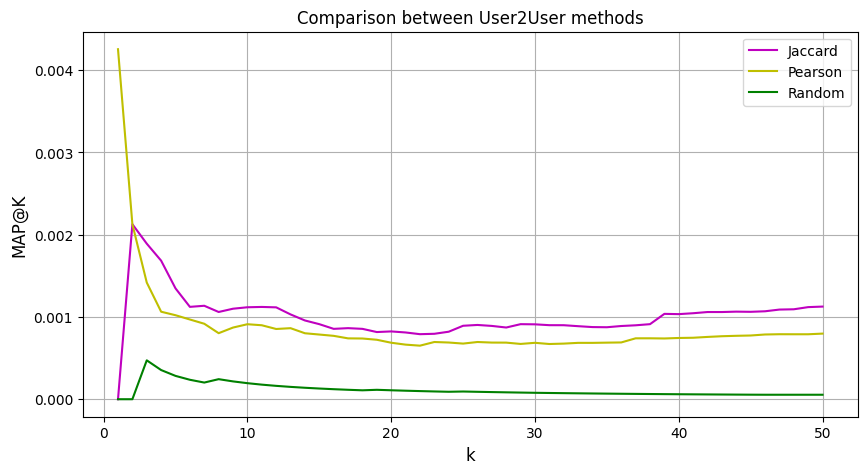

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

for similarity_func, color, label in zip([jaccard, pearson],
                                         ['m', 'y'],
                                         ['Jaccard', 'Pearson']):
  model = User2User(ratings=train_ratings, similarity_func=similarity_func)

  predicted = model.get_test_recommendations(50)
  mapaK = [mapk(test_relevant, predicted, k=k) for k in np.arange(1, 51)]

  ax.plot(np.arange(1, 51), mapaK, color=color, label=label)

random_predicted = [np.random.randint(0, model.n_items, size=50).tolist() for i in np.arange(len(test_users))]
random_mapaK = [mapk(test_relevant, random_predicted, k=k) for k in np.arange(1, 51)]

ax.plot(np.arange(1, 51), random_mapaK, color='g', label='Random')

plt.xlabel('k', fontsize=12)
plt.ylabel('MAP@K', fontsize=12)
plt.grid(True)
plt.legend()
plt.title('Comparison between User2User methods')
plt.show()

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
%%time
model_dense_jaccard = User2User(ratings=train_ratings, similarity_func=jaccard)
pred_dense_jaccard = model_dense_jaccard.get_test_recommendations(50)

CPU times: user 37.3 s, sys: 42 s, total: 1min 19s
Wall time: 49 s


In [ ]:
%%time
model_dense_pearson = User2User(ratings=train_ratings, similarity_func=pearson)
pred_dense_pearson = model_dense_pearson.get_test_recommendations(50)

CPU times: user 30 s, sys: 30.9 s, total: 1min
Wall time: 35.8 s


In [ ]:
def sparse_pearson(ratings: scs.csr_matrix, user_vector: scs.csr_matrix) -> np.array:
    """
    ratings: compressed row matrix with shape (n_users, n_items)
    user_vector: compressed row matrix with shape (1, n_items)

    return: np.array with shape (n_users, )
    """
    # [n_users, n_items] * [n_items, 1] = [n_users, 1] --> [1, n_users] --> [n_users, ]
    product = ratings.dot(user_vector.T).T.toarray()[0]

    norms = scs.linalg.norm(user_vector) * scs.linalg.norm(ratings, axis=1) + 1e-10

    return product / norms

def sparse_jaccard(ratings: scs.csr_matrix, user_vector: scs.csr_matrix) -> np.array:
    """
    ratings: compressed row matrix with shape (n_users, n_items)
    user_vector: compressed row matrix with shape (1, n_items)

    return: np.array with shape (n_users, )
    """
    intersection = ratings.dot(user_vector.T).T.toarray()[0]

    # [n_users, 1] * [1, n_items] = [n_users, n_items], т.е. user_vec, повторенный n_users раз
    repeated_user_vec = scs.csr_matrix(np.ones((ratings.get_shape()[0], 1))).dot(user_vector)

    union = np.asarray((ratings + repeated_user_vec - ratings.multiply(user_vector)).sum(axis=1).T)[0] + 1e-10

    return intersection / union

In [ ]:
class SparseUser2User(User2User):
    def sparse_similarity(self, user_vector: scs.csr_matrix) -> np.array:
        """
        user_vector: compressed row matrix with shape (1, n_items)

        return: np.array
        """
        # убираем данного юзера
        repeated_user_vec = scs.csr_matrix(np.ones((self.n_users, 1))).dot(user_vector)
        users = np.flatnonzero(
            np.asarray(
                (self.sparse_R != repeated_user_vec).sum(axis=1).T
            )
        )

        # соседи
        neighbours = np.flatnonzero(self.similarity_func(self.sparse_R, user_vector) > self.alpha)

        return np.intersect1d(users, neighbours)


    def sparse_recommend(self, uid: int):
        user_vector = self.sparse_R[uid]
        neighbours = self.sparse_R[self.sparse_similarity(user_vector)]

        s = self.similarity_func(neighbours, user_vector)
        recommend_ratings = np.asarray(
            neighbours.multiply(s.reshape(-1, 1)).sum(axis=0)
        )[0] / (np.sum(s) + 1e-10)

        return np.argsort(recommend_ratings)[::-1]


    def get_test_sparse_recommendations(self, k: int):
        test_preds = [self.sparse_recommend(uid) for uid in np.arange(self.n_users)]
        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users].tolist()

In [ ]:
%%time
model_sparse_jaccard = SparseUser2User(ratings=train_ratings, similarity_func=sparse_jaccard)
pred_sparse_jaccard = model_sparse_jaccard.get_test_sparse_recommendations(50)

CPU times: user 8.16 s, sys: 71.9 ms, total: 8.23 s
Wall time: 8.31 s


In [ ]:
%%time
model_sparse_pearson = SparseUser2User(ratings=train_ratings, similarity_func=sparse_pearson)
pred_sparse_pearson = model_sparse_pearson.get_test_sparse_recommendations(50)

CPU times: user 5.83 s, sys: 66.6 ms, total: 5.9 s
Wall time: 5.97 s


In [ ]:
assert pred_dense_jaccard == pred_sparse_jaccard
assert pred_dense_pearson == pred_sparse_pearson

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
model = SparseUser2User(ratings=train_ratings, similarity_func=sparse_jaccard)

In [ ]:
user_id = np.random.randint(0, model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
27,La Camisa Negra,['Juanes']
48,Wild World,['Cat Stevens']
58,Wild Thing,['The Troggs']
77,This D.J.,"['Warren G', 'O.G.L.B.']"
123,Candyman,['Siouxsie And The Banshees']
135,You Know My Name,['Chris Cornell']
176,Handbags & Gladrags,['Rod Stewart']
185,Ruby Tuesday,['The Rolling Stones']
189,Sweet Home Alabama,['Lynyrd Skynyrd']
198,I Like The Way,['Bodyrockers']


In [ ]:
preds = model.get_test_sparse_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
8263,Shape Of My Heart,['Sting']
9694,We Will Rock You,['Queen']
6448,Sweet Dreams (Are Made of This),"['Eurythmics', 'Annie Lennox', 'Dave Stewart']"
805,Zombie,['The Cranberries']
1286,One Of Us,['Joan Osborne']
1056,Don't Speak,['No Doubt']
33436,Believer,['Imagine Dragons']
1073,Smells Like Teen Spirit,['Nirvana']
2555,Californication,['Red Hot Chili Peppers']
7793,∞,['Земфира']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
56069,Another World,['plenka']
56070,Nostalgia,['plenka']
57050,how will i rest in peace if i'm buried by a hi...,['KennyHoopla']
57190,Возвращайся,['angel vox']
58043,Lonely,['Palaye Royale']
58236,Синяя вечность,['Муслим Магомаев']
58541,August,['Intelligency']
58831,swear to god,['Convolk']
60050,Fuji 富士,['FREE FLOW FLAVA']
60139,Wind,['Akeboshi']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Стандартная формула обновления параметров в градиентном спуске $$w^{j+1} = w^{j} - \eta∇L(w^{j}).$$

$$
p_{uk} := p_{uk} - 2η\,(q_{ik}\,(⟨p_{u}, q_{i}⟩ - r_{ui}) + λp_{uk})\\
q_{ik} := q_{ik} - 2η\,(p_{uk}\,(⟨p_{u}, q_{i}⟩ - r_{ui}) + λq_{ik})
$$

\\
**ALS:**

$$p_{u} = (Q^{T}Q + λI)^{-1}Q^{T}r_{u}$$
$$q_{i} = (P^{T}P + λI)^{-1}P^{T}r_{i}$$

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', lr=0.0003, lamb=0.01):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = lr
        self.lamb = lamb
        self.loss = []

    def fit(self, num_iters=5, num_steps=60000):
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                for step in tqdm(range(num_steps)):

                    u = np.random.randint(0, self.n_users)
                    i = np.random.randint(0, self.n_items)

                    # обновляем параметры
                    error = self.P[u, :] @ self.Q[i, :] - self.R[u][i]

                    for k in range(self.dim):
                        self.P[u][k] = self.P[u][k] - self.lr * (self.Q[i][k] * error + self.lamb * self.P[u][k])
                        self.Q[i][k] = self.Q[i][k] - self.lr * (self.P[u][k] * error + self.lamb * self.Q[i][k])


            elif self.mode == 'als':

                for u in tqdm(range(self.n_users)):
                    self.P[u, :] = np.linalg.solve(self.Q.T @ self.Q + self.lamb * np.eye(self.dim), self.Q.T @ self.R[u, :])

                for i in tqdm(range(self.n_items)):
                    self.Q[i, :] = np.linalg.solve(self.P.T @ self.P + self.lamb * np.eye(self.dim), self.P.T @ self.R[:, i])


            # считаем лосс
            self.loss += [np.sum((self.R - self.P @ self.Q.T)**2) + self.lamb * (np.sum(np.linalg.norm(self.P, axis=1)**2) + np.sum(np.linalg.norm(self.P, axis=1)**2))]

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
model_sgd = HiddenVars(ratings=train_ratings, mode='sgd')
model_sgd.fit(num_iters=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
predicted_sgd = model_sgd.get_test_recommendations(50)
mapaK_sgd = [mapk(test_relevant, predicted_sgd, k=k) for k in np.arange(1, 51)]

In [ ]:
mapaK_jaccard = [mapk(test_relevant, pred_dense_jaccard, k=k) for k in np.arange(1, 51)]
mapaK_pearson = [mapk(test_relevant, pred_dense_pearson, k=k) for k in np.arange(1, 51)]

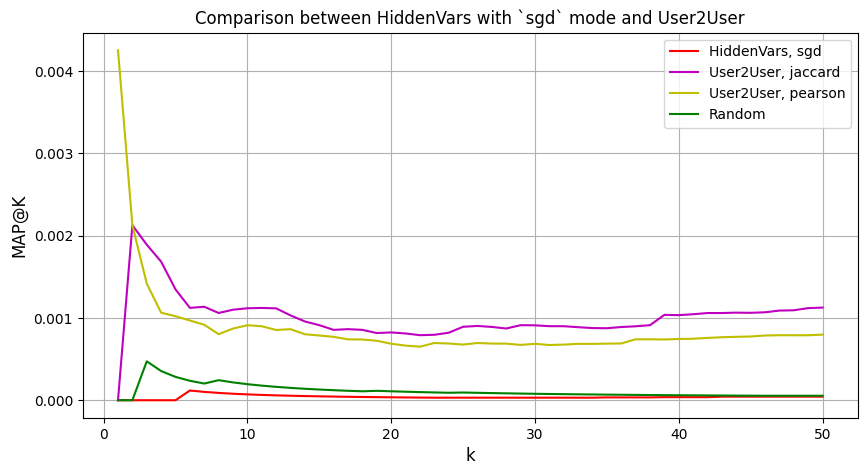

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.arange(1, 51), mapaK_sgd, color='r', label='HiddenVars, sgd')
ax.plot(np.arange(1, 51), mapaK_jaccard, color='m', label='User2User, jaccard')
ax.plot(np.arange(1, 51), mapaK_pearson, color='y', label='User2User, pearson')
ax.plot(np.arange(1, 51), random_mapaK, color='g', label='Random')

plt.xlabel('k', fontsize=12)
plt.ylabel('MAP@K', fontsize=12)
plt.grid(True)
plt.legend()
plt.title('Comparison between HiddenVars with `sgd` mode and User2User')
plt.show()

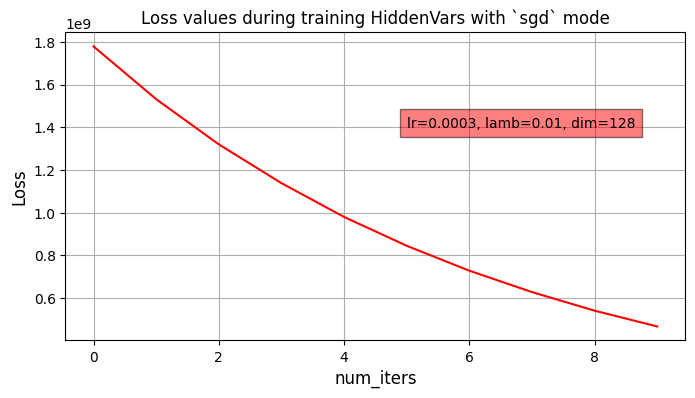

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(np.arange(10), model_sgd.loss, color='r')
ax.text(5, 1.4 * 1e9, f'lr={model_sgd.lr}, lamb={model_sgd.lamb}, dim={model_sgd.dim}', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})

plt.xlabel('num_iters', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.title('Loss values during training HiddenVars with `sgd` mode')
plt.show()

In [ ]:
model_als = HiddenVars(ratings=train_ratings, dim=64, mode='als', lamb=0.001)
model_als.fit(num_iters=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/67313 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/67313 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/67313 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/67313 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/67313 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/67313 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/67313 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/67313 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/67313 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/67313 [00:00<?, ?it/s]

In [ ]:
predicted_als = model_als.get_test_recommendations(50)
mapaK_als = [mapk(test_relevant, predicted_als, k=k) for k in np.arange(1, 51)]

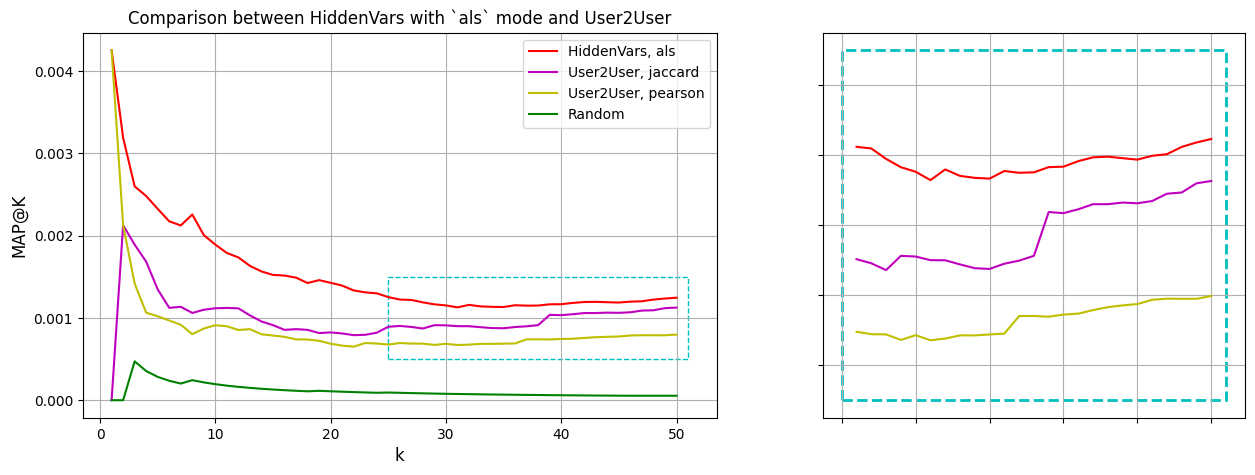

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [3, 2]})

ax[0].plot(np.arange(1, 51), mapaK_als, color='r', label='HiddenVars, als')
ax[0].plot(np.arange(1, 51), mapaK_jaccard, color='m', label='User2User, jaccard')
ax[0].plot(np.arange(1, 51), mapaK_pearson, color='y', label='User2User, pearson')
ax[0].plot(np.arange(1, 51), random_mapaK, color='g', label='Random')

ax[0].add_patch(plt.Rectangle((25, 0.0005), 26, .001, ls='--', ec='c', fc='none'))

ax[0].set_xlabel('k', fontsize=12)
ax[0].set_ylabel('MAP@K', fontsize=12)
ax[0].legend()
ax[0].grid(True)
ax[0].set_title('Comparison between HiddenVars with `als` mode and User2User')

ax[1].plot(np.arange(26, 51), mapaK_als[25:], color='r')
ax[1].plot(np.arange(26, 51), mapaK_jaccard[25:], color='m')
ax[1].plot(np.arange(26, 51), mapaK_pearson[25:], color='y')

ax[1].add_patch(plt.Rectangle((25, 0.0005), 26, 0.001, ls='--', lw=2, ec='c', fc='none'))

ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].grid()

plt.show()

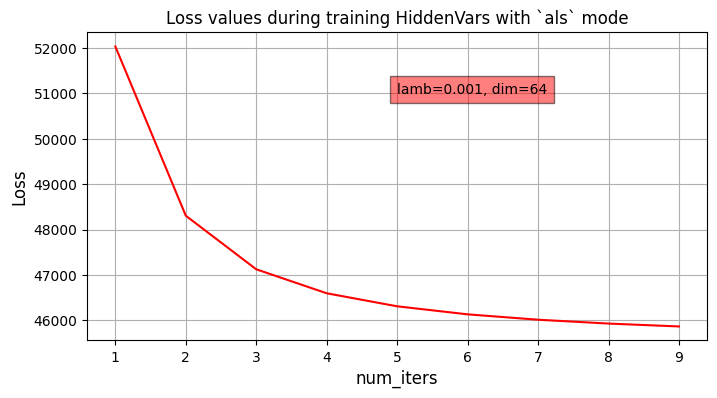

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(np.arange(1, 10), model_als.loss[1:], color='r')
ax.text(5, 51000, f'lamb={model_sgd.lamb}, dim={model_sgd.dim}', bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})

plt.xlabel('num_iters', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.title('Loss values during training HiddenVars with `als` mode')
plt.show()

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Пачка сигарет'].iloc[0].id

preds = model_als.Q @ model_als.Q[example_trackId]
preds = preds / np.sqrt((model_als.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model_als.Q[example_trackId])
similar_tracks

,name,artists,similarity
1831,Пачка сигарет,['КИНО'],1.000000
1906,Группа крови,['КИНО'],0.810010
22118,Мой муж,['Anacondaz'],0.708080
5517,Варвара,['Би-2'],0.702711
15836,Slow Twistin,['Chubby Checker'],0.696363
5151,Soldier Of Fortune,['Deep Purple'],0.689604
204,Love Hurts,['Nazareth'],0.689604
9678,It's A Hard Life,['Queen'],0.689604
1832,Звезда по имени Солнце,['КИНО'],0.687407
9691,Bohemian Rhapsody,['Queen'],0.658696


**Оценка: 10 / 10**

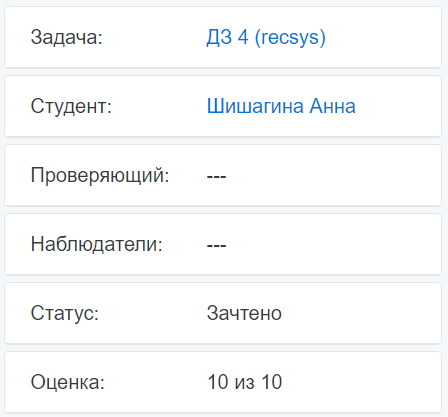